In [40]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.pyplot import figure, show, close, xlabel, ylabel, title
from scipy.constants import k, h, c,e
from scipy.optimize import curve_fit
from spectrapepper import alsbaseline

In [41]:
def f_gaussian(x, amp, mu, sigma, zero):
    """returns the value of a Gaussian function with amplitude amp centered at position mu with width sigma and 
    offset with respect to the x-axis off zero"""
    # amp, mu, sigma, zero = p
    return amp * np.exp(-(x - mu) * (x - mu) / (2.0 * sigma * sigma)) + zero

def f_exp(x, a,b,z):
    """returns an exponential function of the form a*exp(b*x)"""
    return a*np.exp(b*x)+z

Filename: Reynier files/arcturus_wl.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2004,)   float32   

data shape: (2004,)


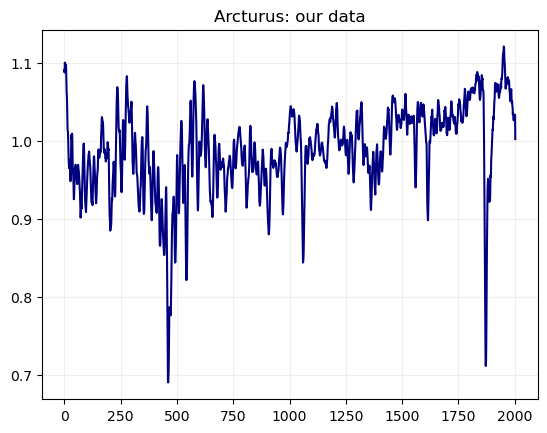

In [42]:
hdulist = fits.open('Reynier files/arcturus_wl.fits')
hdulist.info()
print()

hdr = hdulist[0].header
dat = hdulist[0].data
print(f"data shape: {dat.shape}")


fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(dat,color="navy", label="Vega spectrum")
frame.set_title("Arcturus: our data")
frame.grid(alpha=0.2)
show()
close(fig)

hdulist.close()

[-1.63295085e-01  4.62254805e+02 -2.84579302e+01  9.81995039e-01]


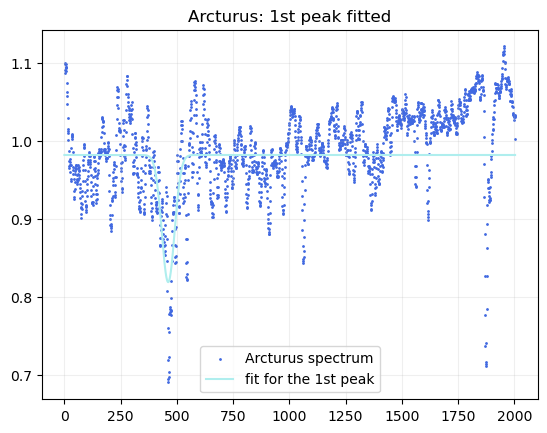

In [43]:
x_range = np.arange(1, dat.size+1)

# dat_smooth=alsbaseline(dat, remove=False)[200:]
dat_smooth=dat
x_range=x_range

# fitting the 1st peak
beta, pcov1 = curve_fit(f_gaussian, x_range[250:600], dat_smooth[250:600], p0=(-1, 450, 5, 1)) 
#amp, mu, sigma, zero

print(beta)

a1,m1,s1,z1=beta


fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_smooth,color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(f_gaussian(x_range,a1,m1,s1,z1),color="paleturquoise", label="fit for the 1st peak")
frame.set_title("Arcturus: 1st peak fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

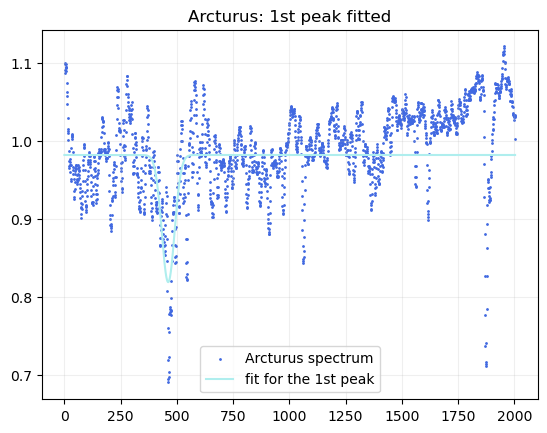

In [44]:

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_smooth,color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(f_gaussian(x_range,a1,m1,s1,z1),color="paleturquoise", label="fit for the 1st peak")
frame.set_title("Arcturus: 1st peak fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

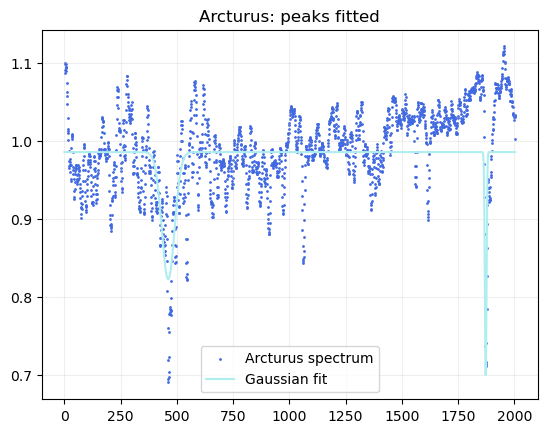

In [45]:
# questionably short

#fitting the last peak
beta, pcov5 = curve_fit(f_gaussian, x_range, dat_smooth, p0=(-0.4, 1900, 50, 1.1))
a5,m5,s5,z5=beta
z = np.mean([z1,z5])

f_composed = f_gaussian(x_range,a1,m1,s1,z)+f_gaussian(x_range,a5,m5,s5,0)
fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_smooth,color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(f_composed,color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

[0.00924643 0.00122183 0.94817456]


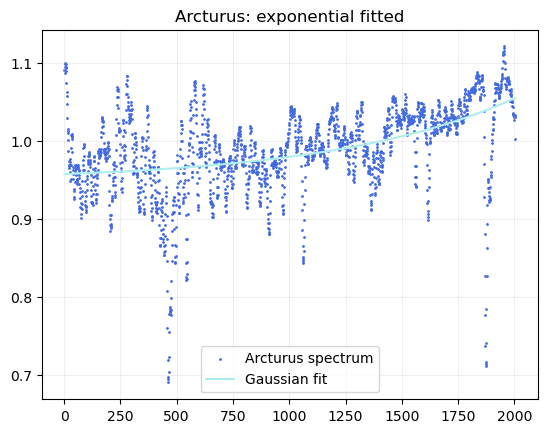

In [46]:
def f_superb(x,a1,m1,s1, a5,m5,s5, a,b,z):
    """Returns a combination of 2 Gaussians plotted on an exponential"""
    gaussian1 = a1 * np.exp(-(x - m1) ** 2 / (2.0 * s1 ** 2))
    gaussian2 = a5 * np.exp(-(x - m5) ** 2 / (2.0 * s5 ** 2))
    exponential = a * np.exp(b * x) + z
    return gaussian1 + gaussian2 + exponential

beta, pcov_exp = curve_fit(f_exp,x_range,dat_smooth,p0=(1,0.0001,1))
print(beta)
exp_a,exp_b,exp_z = beta

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat,color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(x_range,f_exp(x_range,exp_a,exp_b,exp_z),color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: exponential fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)



[-1.64941101e-01  4.63138159e+02 -2.42487478e+01 -3.11432379e-01
  1.87404459e+03 -5.53600128e+00  2.20829083e-03  1.93127076e-03
  9.68461976e-01]


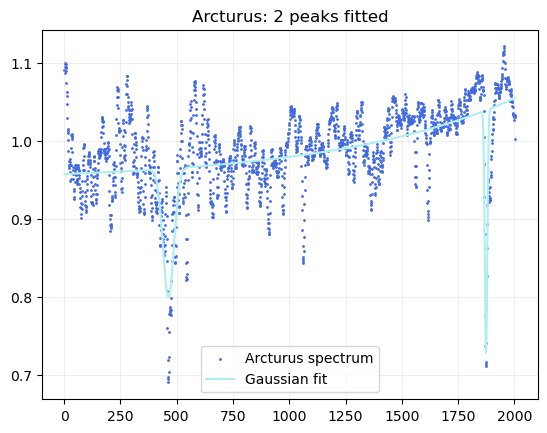

In [47]:
D1=np.array([a1,m1,s1])
D12=np.array([a5,m5,s5])
D_exp=np.array([exp_a,exp_b,1])

# fitting again to the superb function

beta,pcov =curve_fit(f_superb, x_range, dat_smooth, p0=np.concatenate([D1, D12, D_exp]))
np.concatenate([D1, D12, D_exp])
a1,m1,s1,a5,m5,s5,a,b,z=beta
print(beta)

#printing the final fit

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range,dat_smooth,color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(x_range,f_superb(x_range,a1,m1,s1,a5,m5,s5,exp_a,exp_b,exp_z),color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: 2 peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

Gaussian parameters: [[-1.64941106e-01  4.63138160e+02 -2.42487445e+01]
 [-3.11428377e-01  1.87404469e+03 -5.53615318e+00]]
Exponential parameters: [0.00220827 0.00193128 0.968462  ]


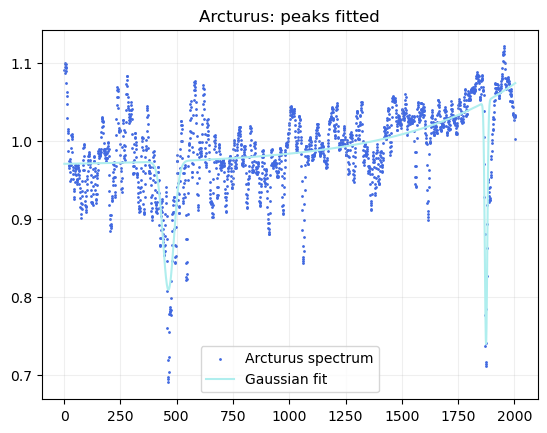

In [48]:
# a function for multiple exponentials

def f_superior(x, *params):
    """Returns a combination of multiple Gaussians plotted on an exponential"""
    num_gaussians = (len(params) - 3) // 3
    y = np.zeros_like(x, dtype=float) #it was having some weird type issues
    for i in range(num_gaussians):
        a = params[3 * i]
        m = params[3 * i + 1]
        s = params[3 * i + 2]
        y += a * np.exp(-(x - m) ** 2 / (2.0 * s ** 2))
    # exponential part
    exp_a, exp_b, exp_z = params[-3:]
    y += exp_a * np.exp(exp_b * x) + exp_z
    return y

initial_gaussians = [D1, D12] # more will be added as needed
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [exp_a, exp_b, exp_z] # flattening the initial guesses for curve_fit

beta, pcov = curve_fit(f_superior, x_range, dat_smooth, p0=initial_guess)

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
exp_params = beta[num_gaussians * 3:]
print("Gaussian parameters:", gaussian_params)
print("Exponential parameters:", exp_params)

# plotting the final fit
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.scatter(x_range, dat_smooth, color="royalblue", label="Arcturus spectrum", s=1)
frame.plot(x_range, f_superior(x_range, *beta), color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

Parameters: [-1.64922625e-01  4.63120528e+02 -2.46668790e+01 -1.53059871e-01
  1.06180608e+03  4.11088325e+00 -5.79114319e-02  1.37530518e+03
  2.39643972e+01 -1.20836773e-01  1.61592734e+03  4.39655385e+00
 -3.09554856e-01  1.87413567e+03 -5.72201004e+00  6.06222378e-03
  1.44026467e-03  9.63034018e-01]
Gaussian parameters: [[-1.64922625e-01  4.63120528e+02 -2.46668790e+01]
 [-1.53059871e-01  1.06180608e+03  4.11088325e+00]
 [-5.79114319e-02  1.37530518e+03  2.39643972e+01]
 [-1.20836773e-01  1.61592734e+03  4.39655385e+00]
 [-3.09554856e-01  1.87413567e+03 -5.72201004e+00]]
Exponential parameters: [0.00606222 0.00144026 0.96303402]


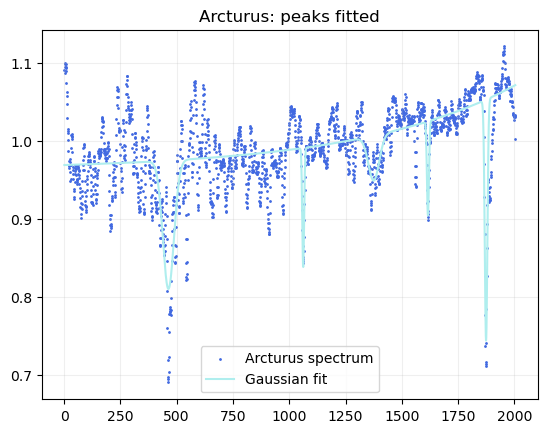

In [49]:
# D1, D5 -> 1st Fe I, O2
D8=np.array([-0.2,1050,5]) #Na I

D9 = np.array([-0.1,1350,20]) #?
D11 = np.array([-0.15,1600,10]) #Fe I

initial_gaussians = [D1,D8,D9,D11,D12]
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [exp_a, exp_b, exp_z]

beta, pcov = curve_fit(f_superior, x_range, dat_smooth, p0=initial_guess)
print("Parameters:", beta) #it's not printing the figure if i remove this line, no idea why

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
exp_params = beta[num_gaussians * 3:]

# poor attempt at error analysis
# gaussian_params_err = pcov[:num_gaussians * 3].reshape((num_gaussians, 3))
# exp_params_err = pcov[num_gaussians * 3:]
err=np.sqrt(np.diag(pcov))
fwhm_err=2*err[2]*np.sqrt(2*np.log(2))

print("Gaussian parameters:", gaussian_params)
print("Exponential parameters:", exp_params)

# plotting the final fit
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.scatter(x_range, dat_smooth, color="royalblue", label="Arcturus spectrum", s=1)
frame.plot(x_range, f_superior(x_range, *beta), color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

[58.0860611   9.68039027 56.43184289 10.35309314 13.47430394]
Fe I peak equivalent width: 58.08606109705832
Na I peak equivalent width: 9.680390272267564
Fe I peak equivalent width: 56.431842890217354
H-alpha peak equivalent width: 10.353093144024374
Oxygen peak equivalent width: 13.474303943040141
Error in FWHMs: 2.7829262388148175


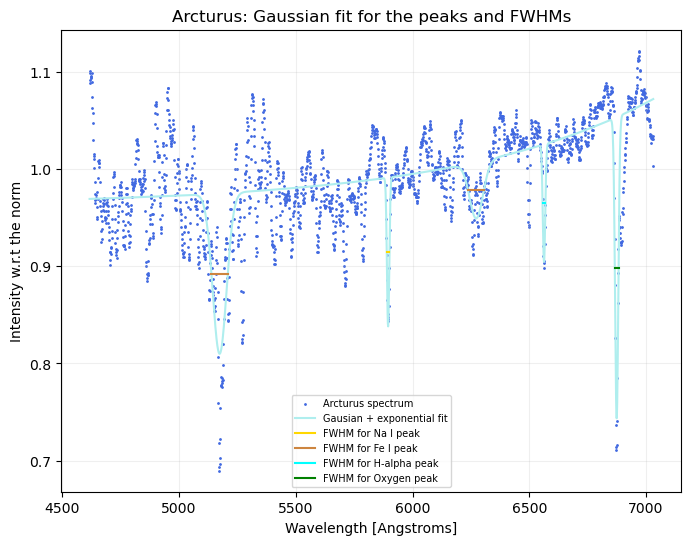

In [50]:
# for Peak in gaussian_params:
#     fwhm,fwhm_err=fwhm_calculator(Peak[2],pcov)
#     fwhm=2*sigma*np.sqrt(2*np.log(2))
    
FWHM = np.array([2*np.abs(Peak[2])*np.sqrt(2*np.log(2)) for Peak in gaussian_params])
print(FWHM)

PeakDescriptions=["Fe I", "Na I", "Fe I", "H-alpha", "Oxygen"]
c=0
for Peak in gaussian_params:
    print(f"{PeakDescriptions[c]} peak equivalent width: {FWHM[c]}")
    c+=1

print(f"Error in FWHMs: {fwhm_err}")

# 1.2056420239473526 4615.032805371546
a_in_pix=1.2056420239473526
a_off = 4615.032805371546

x_range_a = a_in_pix*x_range + a_off

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_a,dat_smooth, color="royalblue", label="Arcturus spectrum",s=1)
frame.plot(x_range_a,f_superior(x_range, *beta),color="paleturquoise", label="Gausian + exponential fit")

p=0

PeakColors=["peru", "gold","peru","cyan","green"]
PeakPositions = []
for Peak in gaussian_params:
    a,m,s=Peak
    PeakPositions.append(m*a_in_pix+a_off)
    f=FWHM[p]
    fwhm_x=np.array((m-f/2,m+f/2))
    
    # getting the exponential fit data to know the y-coordinates of FWHM plot
    exp_a,exp_b,exp_z=exp_params
    z=f_exp(m,exp_a,exp_b,exp_z)    
    
    fwhm_y=np.array((a/2+z,a/2+z))
    
    if (p==0):
        frame.plot(a_in_pix*fwhm_x + a_off,fwhm_y,color=PeakColors[p])
        p+=1
        continue
    
    frame.plot(a_in_pix*fwhm_x + a_off,fwhm_y,color=PeakColors[p], label=f"FWHM for {PeakDescriptions[p]} peak")
    p+=1
    
frame.set_title("Arcturus: Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=7)
show()
close(fig)


Filename: miles spectra/arcturus_miles.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   

data shape: (1, 4367)
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 4367 / length of data axis 1                          NAXIS2  =                    1 / length of data axis 2                          COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H COMMENT ----------------------------------------------------------------------  COMMENT ************************** REDUCEME HEADER ***************************  COMMENT ----------------------------------------------------------------------  HISTOR

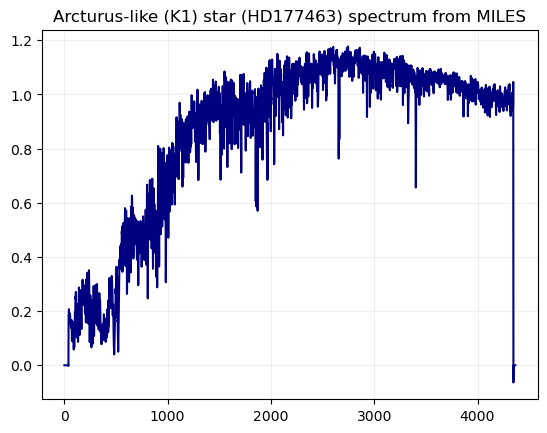

In [51]:
# getting the MILES ccomparison spectrum for Arcturus
#

hdulist = fits.open('miles spectra/arcturus_miles.fits')
hdulist.info()
print()

hdr = hdulist[0].header
dat = hdulist[0].data
print(f"data shape: {dat.shape}")
arcturus_miles = dat[0,:]
print(hdr)

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(arcturus_miles,color="navy", label="Vega spectrum")
frame.set_title("Arcturus-like (K1) star (HD177463) spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

[0.6343251  0.62034994 0.69584715 ... 1.0326638  1.0405912  1.0462704 ]


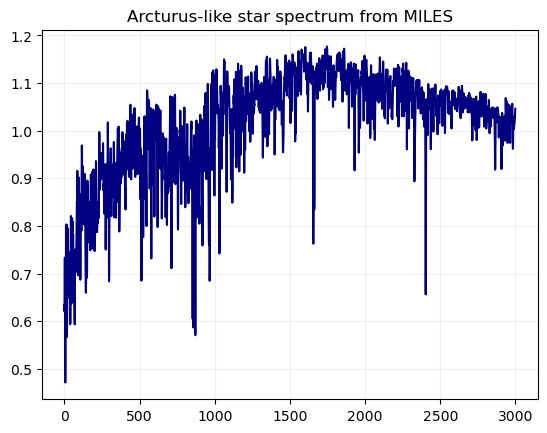

In [52]:
dat_arcturus = arcturus_miles[1000:4000]

print(dat_arcturus)


fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(dat_arcturus,color="navy", label="Arcturus spectrum") # the section of the data that seems relevant
frame.set_title("Arcturus-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)


In [53]:
x_range = np.arange(0, np.size(arcturus_miles[1000:4000]))
x_range_miles = x_range*0.9+3500+1000 # using the pixel -> Angstrom conversion values provided in the header, and accounting for cropping the data

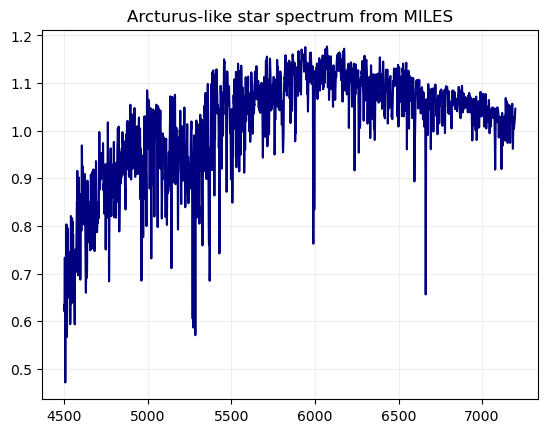

In [54]:
fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(x_range_miles,dat_arcturus,color="navy", label="Arcturus spectrum") # the section of the data that seems relevant
frame.set_title("Arcturus-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

[-4.55646407e+03 -2.09616848e-03  1.07816823e+00]


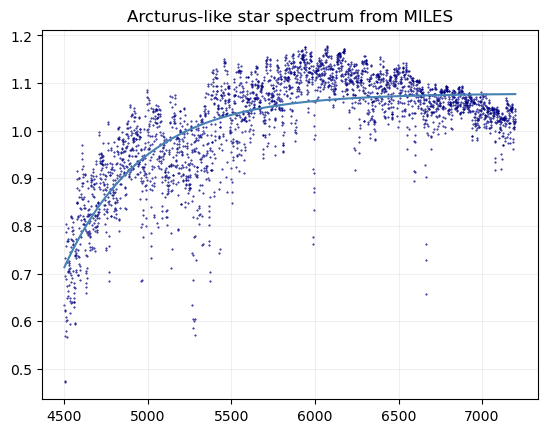

In [55]:
def f_exp(x, a,b,z):
    """returns an exponential function of the form a*exp(b*x)"""
    return a*np.exp(b*x)+z

beta, pcov = curve_fit(f_exp, x_range_miles, dat_arcturus, p0=[2,-0.001,0.4])

print(beta)
exp_a,exp_b,exp_z = beta

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_miles,dat_arcturus,color="navy", label="Arcturus spectrum", s=0.2) # the section of the data that seems relevant
frame.plot(x_range_miles, f_exp(x_range_miles,exp_a,exp_b,exp_z), color="steelblue", label='Fitted Exponential Curve')
frame.set_title("Arcturus-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

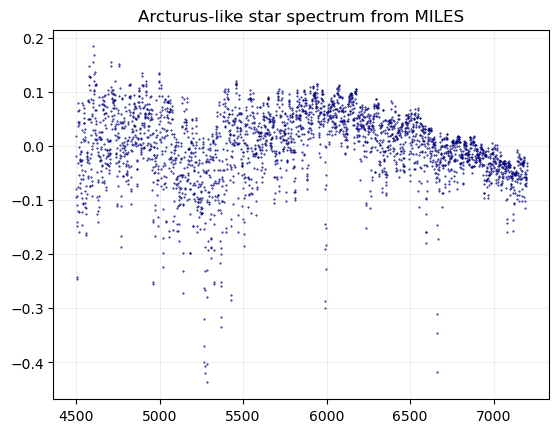

In [56]:
arcturus_miles_line=dat_arcturus-f_exp(x_range_miles,exp_a,exp_b,exp_z)

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_miles,arcturus_miles_line,color="navy", label="Arcturus spectrum", s=0.2) # the section of the data that seems relevant
frame.set_title("Arcturus-like star spectrum from MILES")
frame.grid(alpha=0.2)
show()
close(fig)

In [57]:
# printing peak positions from our data fit

[array([-4.e-01,  6.e+03,  5.e+00]), array([-5.00e-01,  6.65e+03,  5.00e+00])]
Parameters: [-3.20035759e-01  5.99014700e+03  1.15437749e+00 -4.12922249e-01
  6.66277068e+03  1.30464341e+00 -5.17442560e-06  3.11111065e-02]
Gaussian parameters: [[-3.20035759e-01  5.99014700e+03  1.15437749e+00]
 [-4.12922249e-01  6.66277068e+03  1.30464341e+00]]
Line parameters: [-5.17442560e-06  3.11111065e-02]


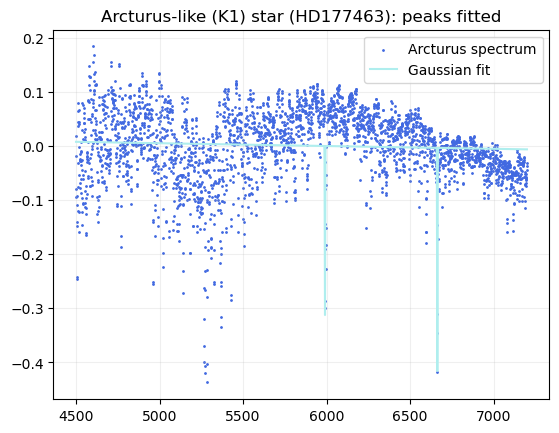

In [58]:
def f_superior_line(x, *params):
    """Returns a combination of multiple Gaussians plotted on a straight line"""
    num_gaussians = (len(params)-2) // 3
    y = np.zeros_like(x, dtype=float) #it was having some weird type issues
    for i in range(num_gaussians):
        a = params[3 * i]
        m = params[3 * i + 1]
        s = params[3 * i + 2]
        y += a * np.exp(-(x - m) ** 2 / (2.0 * s ** 2))
    # exponential part
    a,b = params[-2:]
    y += a*x+b
    return y

# using the parameters for the fit from our data, hence, redefining them in angstroms

gaussian_params_a=np.zeros(np.shape(gaussian_params))

p=0
for Peak in gaussian_params:
    a,m,s=Peak
    gaussian_params_a[p,0]=a
    gaussian_params_a[p,1]=m*a_in_pix+a_off
    gaussian_params_a[p,2]=s*a_in_pix
    p+=1
    
# had to fit them manually anyways due to the large discrepancy between our data and MILES

D1=np.array([-0.4,5300,1])
D8=np.array([-0.4,6000,5]) #Na I
D9 = np.array([-0.3,6300,5]) #?
D11 = np.array([-0.5,6650,5]) #Fe I

# arcturus_miles_line=alsbaseline(arcturus_miles_line, remove=False, lam=1)

initial_gaussians = [D8,D11]
print(initial_gaussians)
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [-0.00001,0]

beta, pcov = curve_fit(f_superior_line, x_range_miles, arcturus_miles_line, p0=initial_guess)
print("Parameters:", beta) #it's not printing the figure if i remove this line, no idea why

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
line_params = beta[num_gaussians * 3:]

# poor attempt at error analysis
# gaussian_params_err = pcov[:num_gaussians * 3].reshape((num_gaussians, 3))
# exp_params_err = pcov[num_gaussians * 3:]
err=np.sqrt(np.diag(pcov))
fwhm_err=2*err[2]*np.sqrt(2*np.log(2))

print("Gaussian parameters:", gaussian_params)
print("Line parameters:", line_params)

# plotting the final fit
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.scatter(x_range_miles, arcturus_miles_line, color="royalblue", label="Arcturus spectrum", s=1)
frame.plot(x_range_miles, f_superior_line(x_range_miles, *beta), color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus-like (K1) star (HD177463): peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

[2.71835125 3.07220044]
Na I peak equivalent width: 2.7183512468578566
H-alpha peak equivalent width: 3.0722004425467637
Error in FWHMs: 0.5294660169101968


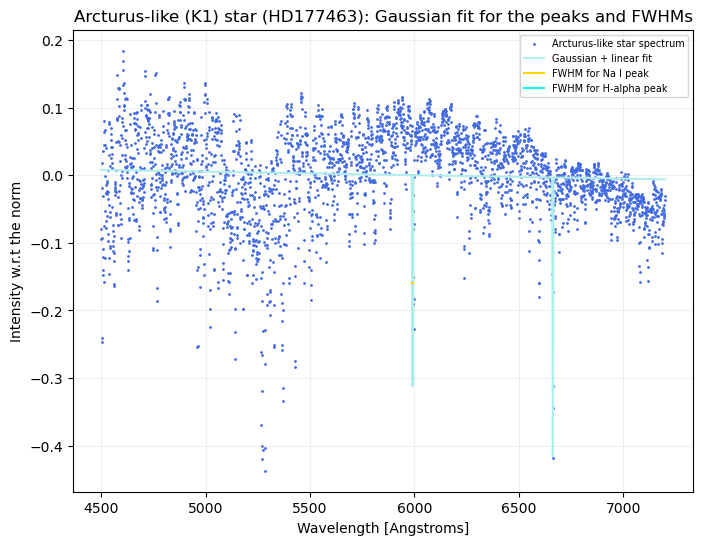

In [59]:
def f_line(x,a,b):
    """returns a straight line equation of the form ax+b"""
    return a*x+b

FWHM = np.array([2*np.abs(Peak[2])*np.sqrt(2*np.log(2)) for Peak in gaussian_params])
print(FWHM)

c=0
PeakDescriptions=["Na I", "H-alpha"]
PeakColors=["gold","cyan"]
for Peak in gaussian_params:
    print(f"{PeakDescriptions[c]} peak equivalent width: {FWHM[c]}")
    c+=1

print(f"Error in FWHMs: {fwhm_err}")

# 1.2056420239473526 4615.032805371546

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_miles,arcturus_miles_line, color="royalblue", label="Arcturus-like star spectrum",s=1)
frame.plot(x_range_miles,f_superior_line(x_range_miles, *beta),color="paleturquoise", label="Gaussian + linear fit")

p=0

PeakPositions = []
for Peak in gaussian_params:
    a,m,s=Peak
    PeakPositions.append(m)
    f=FWHM[p]
    fwhm_x=np.array((m-f/2,m+f/2))

    # getting the exponential fit data to know the y-coordinates of FWHM plot
    l_a,l_b=line_params
    z=f_line(m,l_a,l_b)

    fwhm_y=np.array((a/2+z,a/2+z))

    frame.plot(fwhm_x,fwhm_y,color=PeakColors[p], label=f"FWHM for {PeakDescriptions[p]} peak")
    p+=1

frame.set_title("Arcturus-like (K1) star (HD177463): Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=7)
show()
close(fig)

Parameters: [-1.81818842e-01  5.99216827e+03  3.24461777e+00 -4.16249065e-01
  6.66276949e+03  1.32999263e+00 -4.19206577e+03 -2.07647689e-03
  1.08016863e+00]
Gaussian parameters: [[-1.81818842e-01  5.99216827e+03  3.24461777e+00]
 [-4.16249065e-01  6.66276949e+03  1.32999263e+00]]
Exponential parameters: [-4.19206577e+03 -2.07647689e-03  1.08016863e+00]


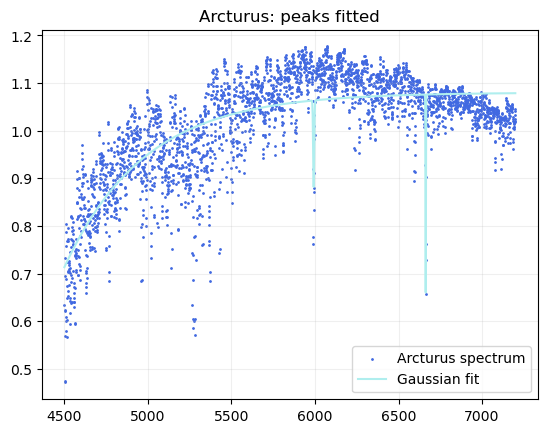

In [60]:
# trying to fit the Gaussians on an exponential instead of a line (without subtracting it), as the line is clearly not working

initial_guess = [item for sublist in initial_gaussians for item in sublist] + [exp_a, exp_b, exp_z]

beta, pcov = curve_fit(f_superior, x_range_miles, dat_arcturus, p0=initial_guess)
print("Parameters:", beta) #it's not printing the figure if i remove this line, no idea why

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
exp_params = beta[num_gaussians * 3:]

err=np.sqrt(np.diag(pcov))
fwhm_err=2*err[2]*np.sqrt(2*np.log(2))

print("Gaussian parameters:", gaussian_params)
print("Exponential parameters:", exp_params)

# plotting the final fit
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.scatter(x_range_miles, dat_arcturus, color="royalblue", label="Arcturus spectrum", s=1)
frame.plot(x_range_miles, f_superior(x_range_miles, *beta), color="paleturquoise", label="Gaussian fit")
frame.set_title("Arcturus: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)